#Итоговый проект по курсу «Data Analyst Junior»

##Загрузка данных

In [338]:
import pandas as pd
import sqlite3
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score, GridSearchCV
import re
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro, ttest_ind
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [339]:
conn = sqlite3.connect('/content/shop_database.db')

In [340]:
personal_data = pd.read_sql_query('SELECT * FROM personal_data', conn)
personal_data_coeffs = pd.read_sql_query('SELECT * FROM personal_data_coeffs', conn)
purchases = pd.read_sql_query('SELECT * FROM purchases', conn)

In [341]:
print(personal_data.shape)
personal_data.head()

(89241, 6)


,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [342]:
print(personal_data_coeffs.shape)
personal_data_coeffs.head()

(104989, 5)


,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [343]:
print(purchases.shape)
purchases.head()

(786260, 7)


,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [344]:
lost_data = pd.read_csv('/content/personal_data.csv')
print(lost_data.shape)
lost_data.head()

(15748, 5)


,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


##Работа с данными

###Датасет personal_data_coeffs

####Устранение пропусков

In [345]:
personal_data_coeffs

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072
...,...,...,...,...,...
104984,177998,4.740988,0.364797,1.165888,0.5072
104985,177999,7.303172,0.431899,1.317100,0.4304
104986,178001,5.241579,0.430391,0.356182,0.2576
104987,178002,7.542436,-0.290921,0.800338,0.4304


<Axes: >

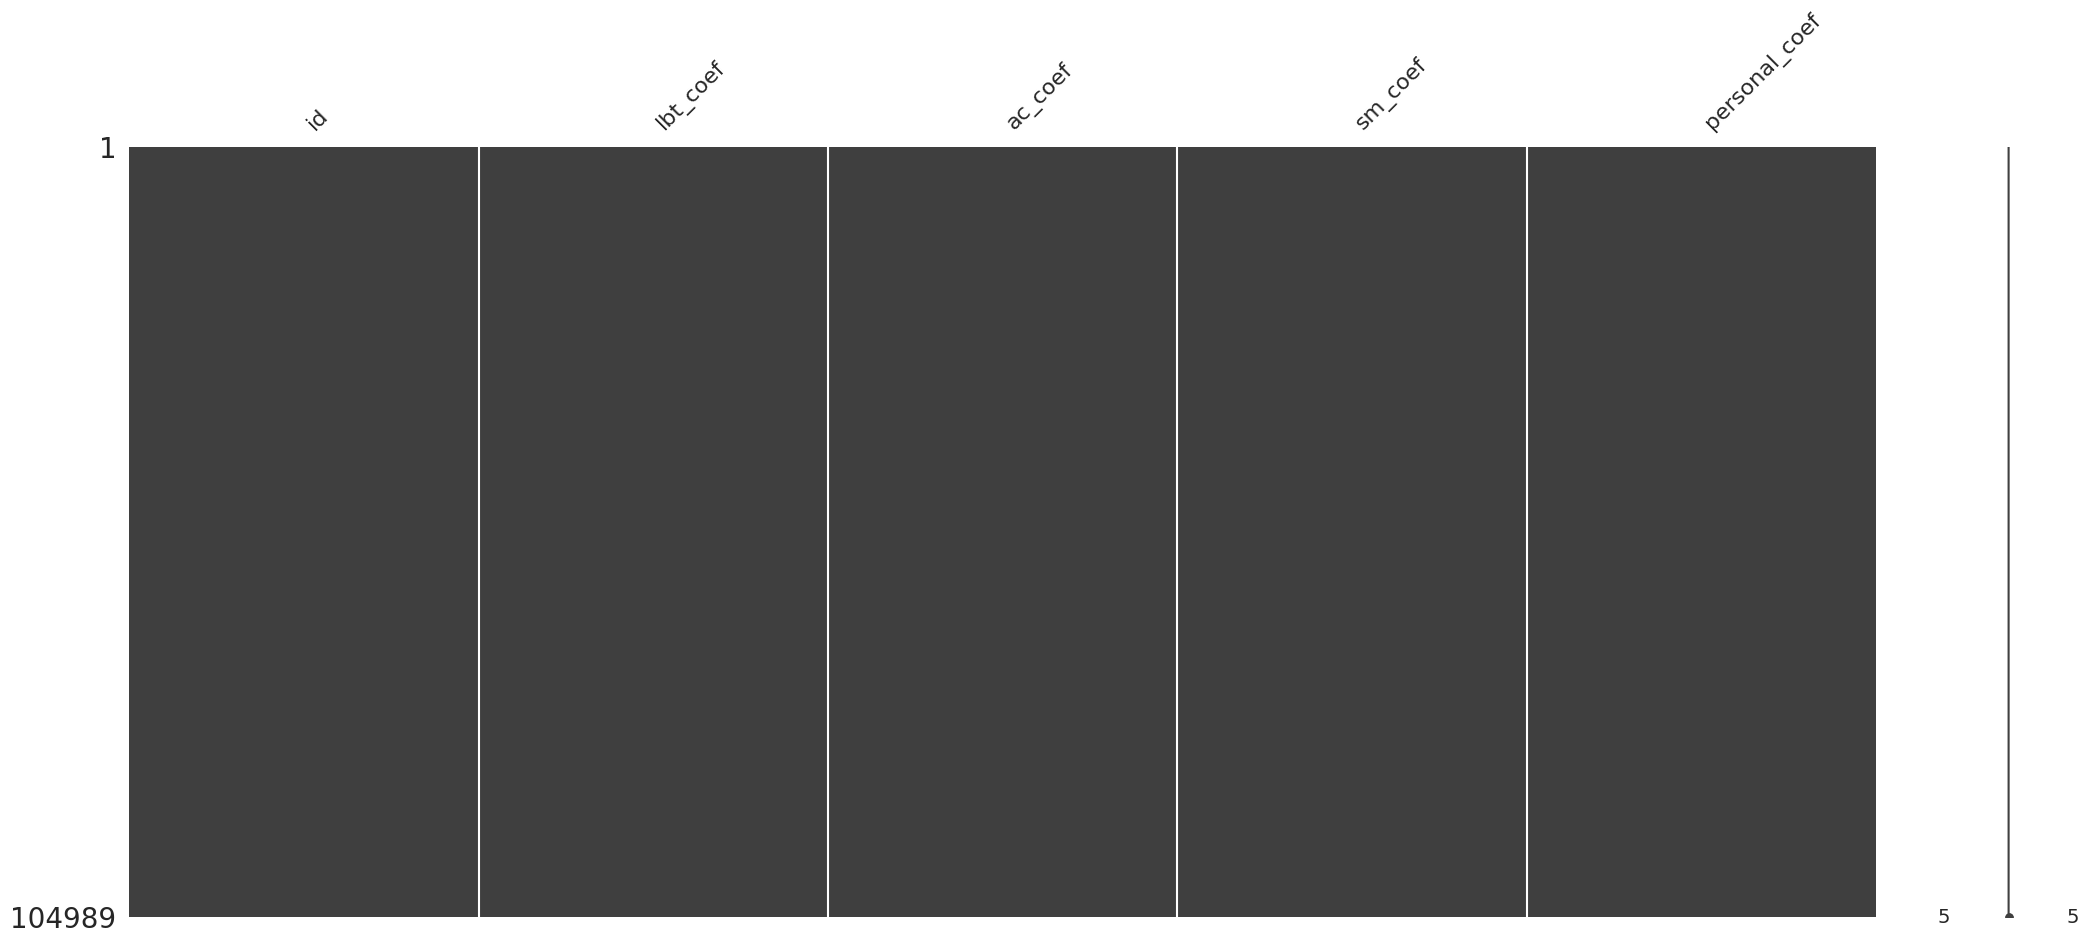

In [346]:
msno.matrix(personal_data_coeffs)

####Работа с выбросами и аномалиями

В датасете с коэффицентами в этом надобности нет

####Проверка на дубликаты

In [347]:
personal_data_coeffs.duplicated().sum()

0

###Датасет purchases

####Устранение пропусков

In [348]:
purchases

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки/черный,7999,1.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,20
786258,178004,Пакет,коричневый,12,NaN,0,20


поменяю значения product_sex для дальнейшей обработки

In [349]:
purchases['product_sex'] = purchases['product_sex'].apply(lambda x: 2 if x==1 else x)
purchases

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,2.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки/черный,7999,2.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,2.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,2.0,0,20
786258,178004,Пакет,коричневый,12,NaN,0,20


In [350]:
for column in purchases.columns:
    print(column)
    print(purchases[column].unique())

id
[     0      3      4 ... 178001 178002 178004]
product
['Велосипед горный женский Stern Mira 2.0 26"' 'Стол Outventure'
 'Набор Outventure: стол + 4 стула' ...
 'Клюшка детская Bauer Vapor 3X, Flex 55, P92'
 'Футболка мужская Reebok United By Fitness'
 'Бутсы мужские adidas Predator 19.3 TF']
colour
['белый/синий' 'зелёный' 'бежевый' ... 'бордовый/прозрачный/голубой'
 'синий/голубой/золотой/желтый' 'черный/циан']
cost
[ 13599   1499   4799 ...   5700  49899 174999]
product_sex
[ 0. nan  2.]
base_sale
[1 0]
dt
[ 7 37 13 27 34  0  1  2 32  3  8 11 17 18 29 30  6 14 33 35 36 42 49 25
 39 55 56  4 26 28 45 51  5 15 50 52 12 16 19 21 22 23 31  9 58 41 44 57
 47 10 54 43 38 46 53 24 40 20 48]


In [351]:
purchases.isna().sum()

,0
id,0
product,0
colour,119524
cost,0
product_sex,314712
base_sale,0
dt,0


<Axes: >

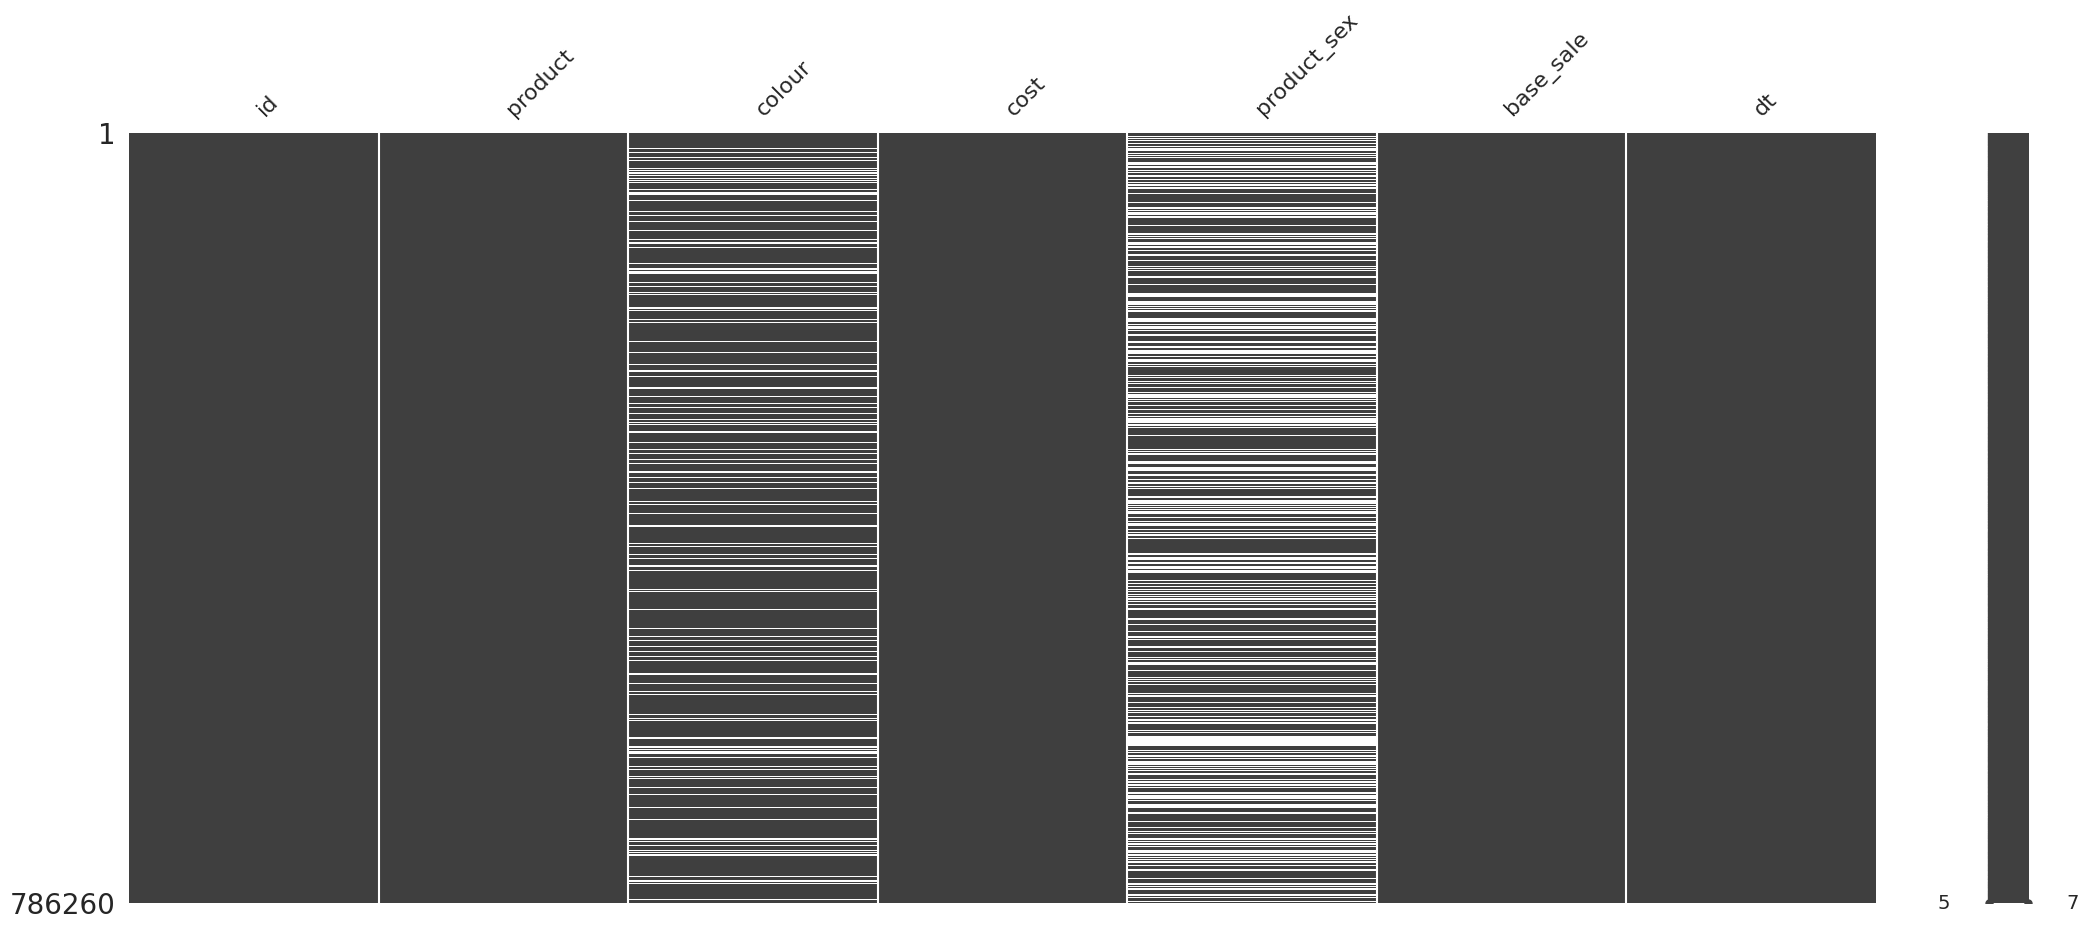

In [352]:
msno.matrix(purchases)

In [353]:
purchases[purchases.product_sex.isna()]

,id,product,colour,cost,product_sex,base_sale,dt
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27
7,4,Роликовые коньки детские Roces Orlando III,черный/розовый,9199,NaN,0,0
8,4,Шлем FILA NRK FUN,белый,4999,NaN,0,0
...,...,...,...,...,...,...,...
786236,177999,"Велосипед городской Stern Urban 28"", 2022",None,25199,NaN,0,49
786237,177999,Палатка 3-местная Outventure Cadaques 3,None,7999,NaN,0,49
786245,178001,Мини-степпер Torneo Massage S-231,серый,4999,NaN,0,13
786251,178002,Бейсболка New Era 9Forty MLB New York Yankees,None,1899,NaN,0,57


In [354]:
def fill_sex(row):
    if pd.isna(row['product_sex']):
        lower_name = row['product'].lower()
        if 'муж' in lower_name or 'мальч' in lower_name:
            return 2
        elif 'женск' in lower_name or 'женщ' in lower_name or 'девоч' in lower_name:
            return 0
        else:
            return 1
    return row['product_sex']

purchases['product_sex'] = purchases.apply(fill_sex, axis=1)

2 для мужских вещей, 0 для женских вещей, 1 для вещей всех полов

In [355]:
purchases

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,1.0,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,1.0,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,2.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,1.0,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки/черный,7999,2.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,2.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,2.0,0,20
786258,178004,Пакет,коричневый,12,1.0,0,20


In [356]:
purchases[purchases.colour.isna()]

,id,product,colour,cost,product_sex,base_sale,dt
13,4,Куртка утепленная для девочек Outventure,None,2999,0.0,0,32
27,6,Ботинки утепленные для мальчиков Reima Uskallus,None,3449,2.0,0,30
41,7,Бутсы для мальчиков Nike Jr. Tiempo Legend 9 A...,None,8799,2.0,0,49
52,11,Сандалии женские Outventure Aqua,None,1599,0.0,0,4
54,11,Рюкзак детский Demix,None,799,1.0,0,26
...,...,...,...,...,...,...,...
786246,178001,Полуботинки мужские Outventure Crosser,None,2499,2.0,0,45
786250,178002,Кеды мужские Reebok Royal Techque T,None,3499,2.0,0,57
786251,178002,Бейсболка New Era 9Forty MLB New York Yankees,None,1899,1.0,0,57
786253,178004,Кроссовки мужские FILA Regen,None,5999,2.0,0,9


In [357]:
purchases[~purchases.colour.isna()]

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,1.0,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,1.0,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,2.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,1.0,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки/черный,7999,2.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,2.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,2.0,0,20
786258,178004,Пакет,коричневый,12,1.0,0,20


Восстановить цвет из других данных не получится, заполню константным значением "Неизвестно"

In [358]:
purchases['colour'] = purchases['colour'].fillna('неизвестно')

<Axes: >

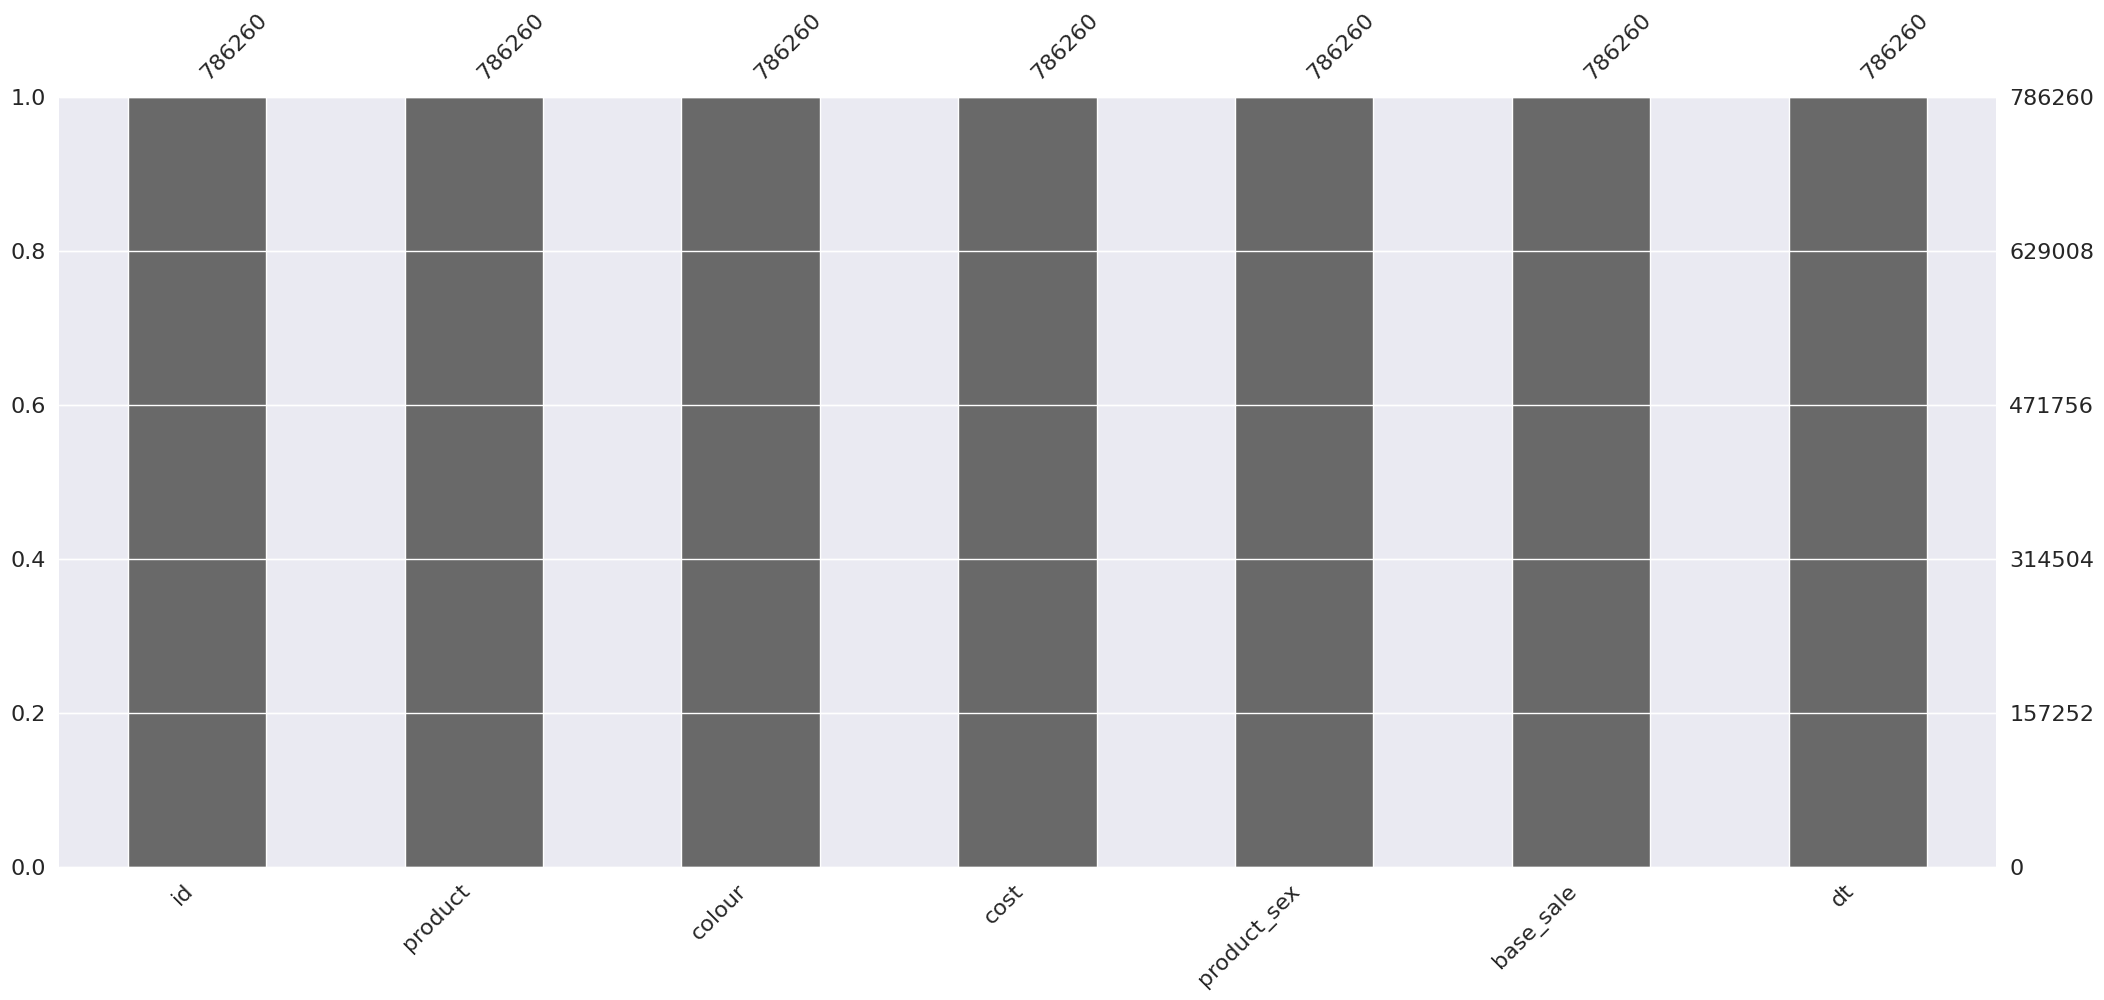

In [359]:
msno.bar(purchases)

####Работа с выбросами и аномалиями

In [360]:
df_copy = purchases.copy()

<Axes: ylabel='cost'>

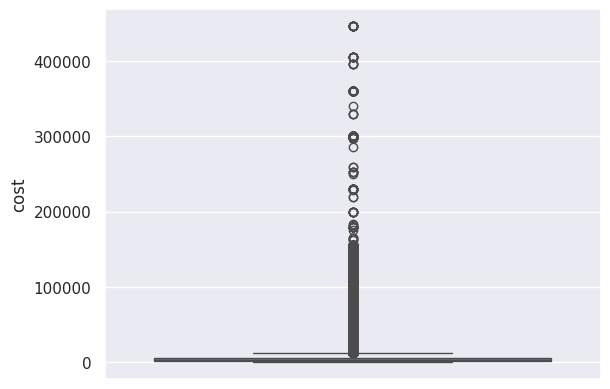

In [361]:
sns.boxplot(purchases.cost)

In [362]:
purchases[purchases.cost > 400000]

,id,product,colour,cost,product_sex,base_sale,dt
23511,5319,Эхолот Lowrance HDS-12 LIVE с датчиком Active ...,неизвестно,446420,1.0,0,45
46020,10318,Эхолот Lowrance HDS-12 LIVE с датчиком Active ...,неизвестно,446420,1.0,0,49
49245,11072,"Велосипед горный Merida One Forty 700 27.5""",зеленый/красный,405999,1.0,0,23
51589,11613,Эхолот Lowrance HDS-12 LIVE с датчиком Active ...,неизвестно,446420,1.0,0,47
64475,14520,"Велосипед горный Merida One Forty 700 27.5""",зеленый/красный,405999,1.0,0,23
132510,29699,"Велосипед горный Merida One Forty 700 27.5""",зеленый/красный,405999,1.0,0,24
150396,33820,"Велосипед горный Merida One Forty 700 27.5""",зеленый/красный,405999,1.0,0,22
177834,40024,Эхолот Lowrance HDS-12 LIVE с датчиком Active ...,неизвестно,446420,1.0,0,43
218745,49636,Эхолот Lowrance HDS-12 LIVE с датчиком Active ...,неизвестно,446420,1.0,0,40
261268,59553,Эхолот Lowrance HDS-12 LIVE с датчиком Active ...,неизвестно,446420,1.0,0,53


In [363]:

#lof = LocalOutlierFactor()
#pred = lof.fit_predict(purchases[['cost']])
#pred

In [364]:
#df_copy['anomaly'] = pred

In [365]:
#df_copy[df_copy['anomaly'] == -1].head(50)

Изучив выбросы, предложенные LocalOutlierFactor'ом, я пришел к выводу что не стоит их удалять, т.к. они не являются следствием ошибки ввода или подобного. (Для своего удобства я закомментировал код с lof, т.к. он затрачивает много времени на выполнение)

####Проверка на дубликаты

In [366]:
purchases.duplicated().sum()

0

####Прочая работа

<Axes: >

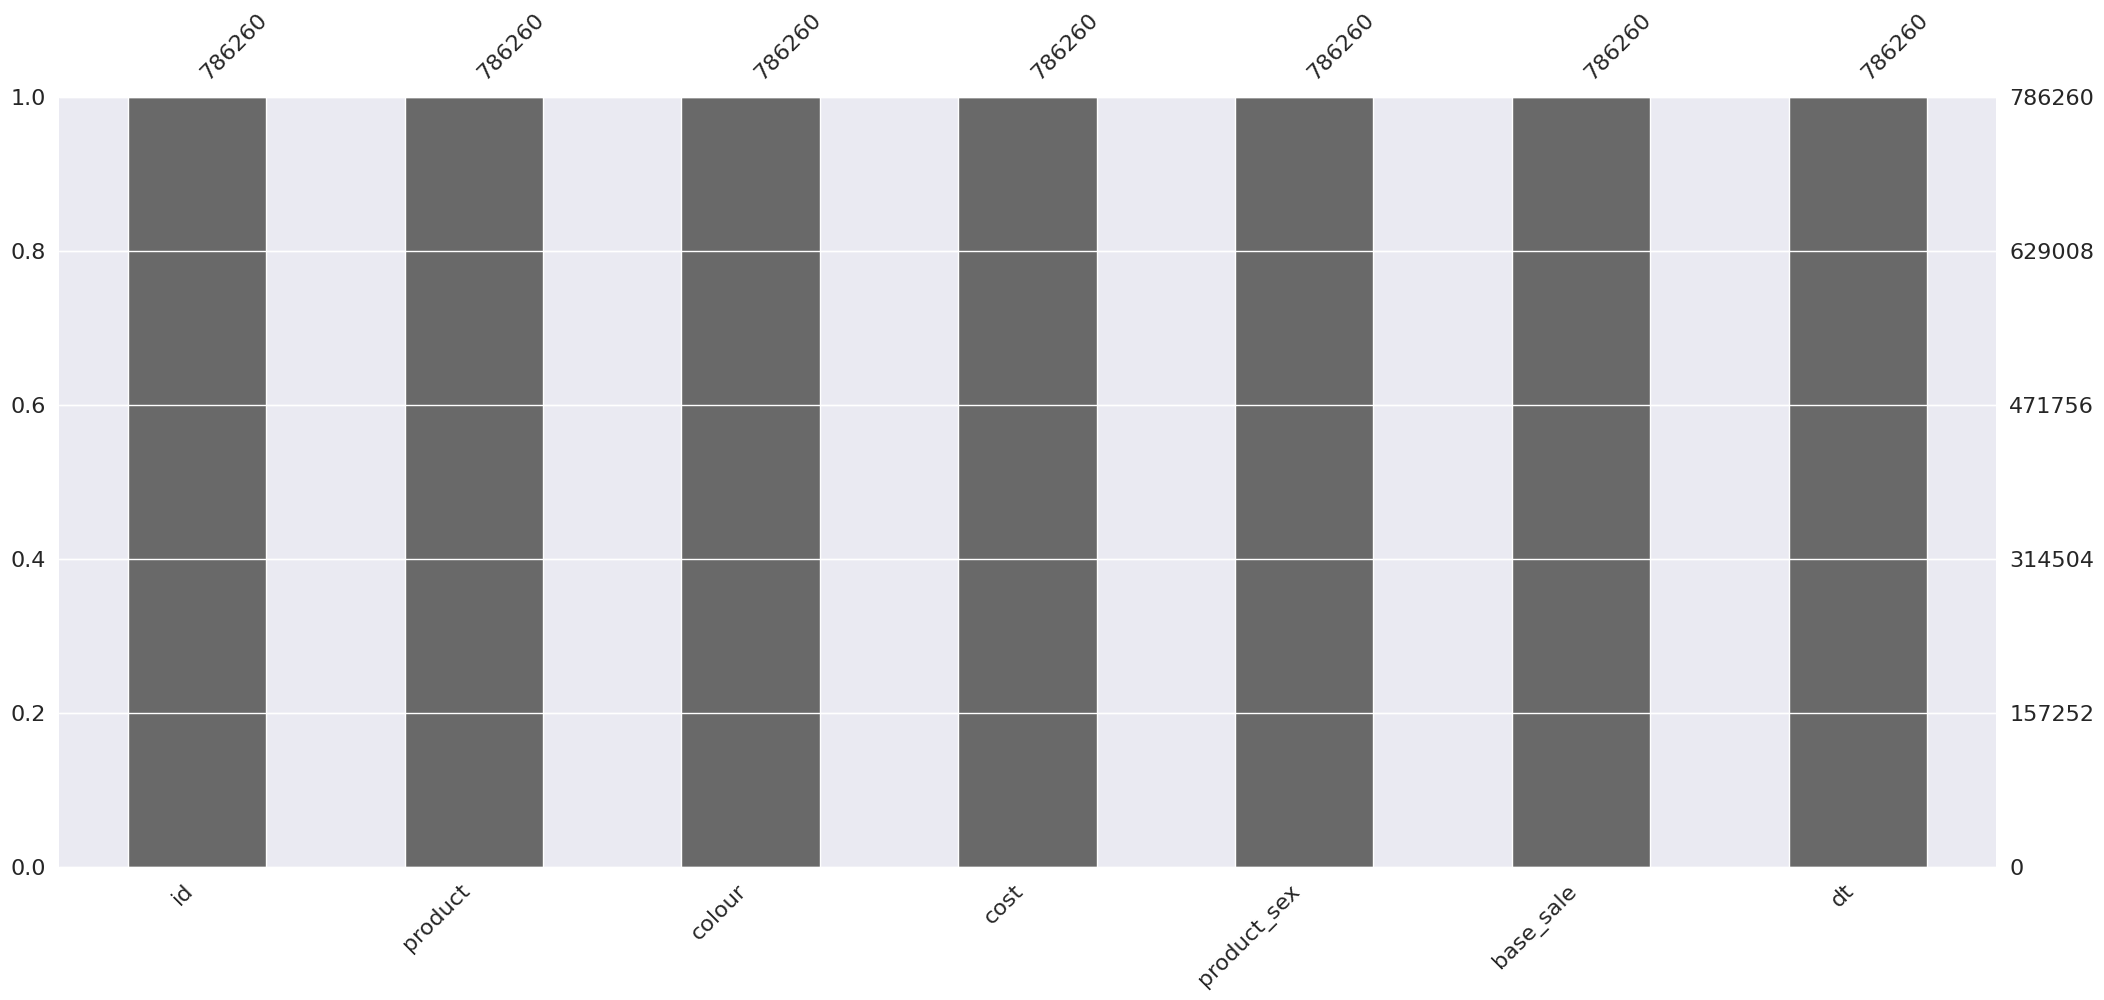

In [367]:
msno.bar(purchases)

In [368]:
purchases.colour

,colour
0,белый/синий
1,зелёный
2,бежевый
3,белый
4,мультицвет
...,...
786255,хаки/черный
786256,черный/серый
786257,черный/серый
786258,коричневый


In [369]:
purchases['colour'].nunique()

1694

In [370]:
purchases['colour'] = purchases['colour'].apply(lambda x: 'мультицвет' if '/' in x else x)
purchases['colour'] = purchases['colour'].apply(lambda x: x.split('-')[1] if '-' in x else x)
purchases['colour'] = purchases['colour'].apply(lambda x: x.split('.')[1] if '.' in x else x)
purchases['colour'] = purchases['colour'].apply(lambda x: x.lower())
purchases['colour'] = purchases['colour'].apply(lambda x: x.replace('ё', 'е'))
purchases['colour'] = purchases['colour'].apply(lambda x: 'неизвестно' if re.search(r'[a-zA-Z]', x) else x)
purchases.colour

,colour
0,мультицвет
1,зеленый
2,бежевый
3,белый
4,мультицвет
...,...
786255,мультицвет
786256,мультицвет
786257,мультицвет
786258,коричневый


In [371]:
for u in purchases['colour'].unique():
    print(u)

мультицвет
зеленый
бежевый
белый
серый
розовый
неизвестно
черный
синий
красный
желтый
милитари
коралловый
сливовый
морской
ореховый
коричневый
голубой
баклажановый
пионовый
фисташковый
терракотовый
фуксия
малиновый
вишневый
графитовый
хаки
дымчатый
оливковый
серебряный
еловый
сиреневый
болотный
небесный
салатовый
бордовый
лиловый
лососевый
сапфировый
кремовый
медный
оранжевый
прозрачный
васильковый
алый
лавандовый
бирюзовый
охра
морковный
матовый
лайм
фиолетовый
абрикосовый
ирис
черничный
яблочный
мятный
серебристый
медовый
индиго
фиалковый
кофейный
песочный
хвойный
какао
персиковый
каштановый
изумрудный
орхидея
молочный
сиинй
принт
горчичный
лазурный
золотой
малахитовый
пудровый
петроль
точка
винный
меланж
металлик
камуфляж
аквамарин
кирпичный
янтарный
ультрамарин
вереск
лимонный
виноградный
ягодный
пепельный
ежевичный
разноцветный
стальной
ирисовый
леопардовый
кость
бронзовый
камуфляжный
хром
коралл
дай
хамелеон
пурпурный
лаймовый
золото
бесцветный
гранитный
антрацит
неопределенный
н

In [372]:
purchases['colour'].nunique()

151

###Датасет personal_data

####Устранение пропусков

In [373]:
personal_data = pd.concat([personal_data, lost_data])
df_copy = personal_data.copy()
df_copy.head()

,id,gender,age,education,city,country
0,0,0.0,36,среднее,1201,32
1,4,0.0,35,среднее,1134,32
2,6,1.0,52,среднее,1188,32
3,7,0.0,37,среднее,1198,32
4,9,0.0,48,среднее,1134,32


<Axes: >

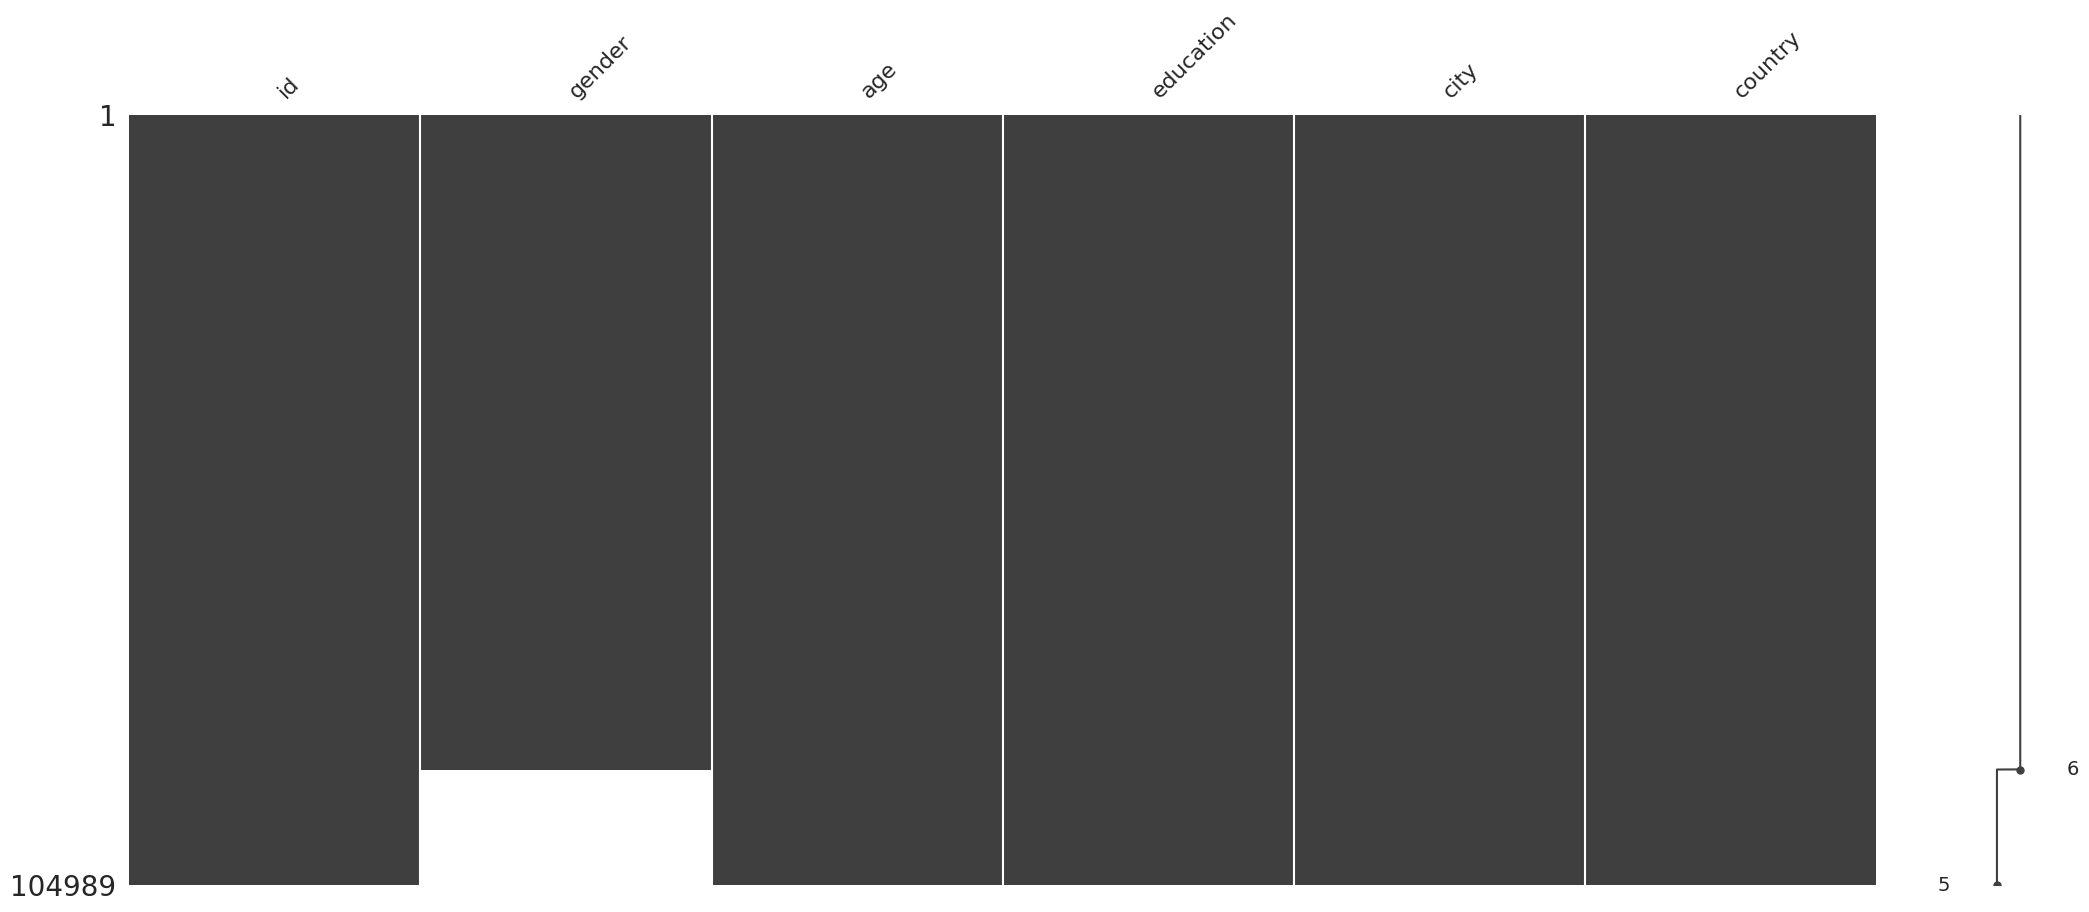

In [374]:
msno.matrix(personal_data)

Воспользуюсь логистической регрессией для заполнения пропусков. Для этого предварительно закодирую и нормализую данные. Так же перенесу из датасета purchases колонку purchases, чтобы увидеть предметы какой половой принадлежности чаще покупал клиент (это будет весьма информативная колонка для модели)

In [375]:
purchases

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",мультицвет,13599,0.0,1,7
1,0,Стол Outventure,зеленый,1499,1.0,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,1.0,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,2.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,1.0,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,мультицвет,7999,2.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,мультицвет,24299,2.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,мультицвет,24299,2.0,0,20
786258,178004,Пакет,коричневый,12,1.0,0,20


In [376]:
purchases_filtered = purchases[purchases['product_sex'] != 1]

most_frequence_sex = purchases_filtered.groupby('id')['product_sex'].agg(lambda x: x.mode()[0])

most_frequence_sex

,product_sex
id,
0,0.0
3,2.0
4,0.0
6,2.0
7,0.0
...,...
177998,0.0
177999,2.0
178001,2.0


In [377]:
most_frequence_sex = most_frequence_sex.reset_index()
most_frequence_sex

,id,product_sex
0,0,0.0
1,3,2.0
2,4,0.0
3,6,2.0
4,7,0.0
...,...,...
96356,177998,0.0
96357,177999,2.0
96358,178001,2.0
96359,178002,2.0


In [378]:
df_copy

,id,gender,age,education,city,country
0,0,0.0,36,среднее,1201,32
1,4,0.0,35,среднее,1134,32
2,6,1.0,52,среднее,1188,32
3,7,0.0,37,среднее,1198,32
4,9,0.0,48,среднее,1134,32
...,...,...,...,...,...,...
15743,135183,NaN,44,среднее,1134,32
15744,125993,NaN,46,среднее,1134,32
15745,167019,NaN,71,среднее,1134,32
15746,116355,NaN,32,среднее,1188,32


In [379]:
df_copy = df_copy.merge(most_frequence_sex, on='id', how='left')
df_copy

,id,gender,age,education,city,country,product_sex
0,0,0.0,36,среднее,1201,32,0.0
1,4,0.0,35,среднее,1134,32,0.0
2,6,1.0,52,среднее,1188,32,2.0
3,7,0.0,37,среднее,1198,32,0.0
4,9,0.0,48,среднее,1134,32,0.0
...,...,...,...,...,...,...,...
104984,135183,NaN,44,среднее,1134,32,0.0
104985,125993,NaN,46,среднее,1134,32,2.0
104986,167019,NaN,71,среднее,1134,32,0.0
104987,116355,NaN,32,среднее,1188,32,2.0


In [380]:
df_copy.isna().sum()

,0
id,0
gender,15748
age,0
education,0
city,0
country,0
product_sex,8628


In [381]:
df_copy['product_sex'] = df_copy['product_sex'].fillna(1)
df_copy.isna().sum()

,0
id,0
gender,15748
age,0
education,0
city,0
country,0
product_sex,0


In [382]:
personal_data_coeffs[['id', 'personal_coef']]

,id,personal_coef
0,0,0.5072
1,3,0.4304
2,4,0.5072
3,6,0.4304
4,7,0.5072
...,...,...
104984,177998,0.5072
104985,177999,0.4304
104986,178001,0.2576
104987,178002,0.4304


In [383]:
df_copy = df_copy.merge(personal_data_coeffs[['id', 'personal_coef']], on='id', how='left')
df_copy

,id,gender,age,education,city,country,product_sex,personal_coef
0,0,0.0,36,среднее,1201,32,0.0,0.5072
1,4,0.0,35,среднее,1134,32,0.0,0.5072
2,6,1.0,52,среднее,1188,32,2.0,0.4304
3,7,0.0,37,среднее,1198,32,0.0,0.5072
4,9,0.0,48,среднее,1134,32,0.0,0.5072
...,...,...,...,...,...,...,...,...
104984,135183,NaN,44,среднее,1134,32,0.0,0.4304
104985,125993,NaN,46,среднее,1134,32,2.0,0.4304
104986,167019,NaN,71,среднее,1134,32,0.0,0.5072
104987,116355,NaN,32,среднее,1188,32,2.0,0.4304


In [384]:
le = LabelEncoder()
enc_data = le.fit_transform(df_copy['education'])
df_copy['education'] = enc_data
df_copy

,id,gender,age,education,city,country,product_sex,personal_coef
0,0,0.0,36,1,1201,32,0.0,0.5072
1,4,0.0,35,1,1134,32,0.0,0.5072
2,6,1.0,52,1,1188,32,2.0,0.4304
3,7,0.0,37,1,1198,32,0.0,0.5072
4,9,0.0,48,1,1134,32,0.0,0.5072
...,...,...,...,...,...,...,...,...
104984,135183,NaN,44,1,1134,32,0.0,0.4304
104985,125993,NaN,46,1,1134,32,2.0,0.4304
104986,167019,NaN,71,1,1134,32,0.0,0.5072
104987,116355,NaN,32,1,1188,32,2.0,0.4304


In [385]:
ss = StandardScaler()
scaled_data = ss.fit_transform(df_copy[['age', 'education', 'city', 'country', 'product_sex']])
df_copy[['age', 'education', 'city', 'country', 'product_sex']] = scaled_data
df_copy

,id,gender,age,education,city,country,product_sex,personal_coef
0,0,0.0,-0.164185,0.526402,0.374836,0.011575,-1.256831,0.5072
1,4,0.0,-0.245598,0.526402,0.001180,0.011575,-1.256831,0.5072
2,6,1.0,1.138417,0.526402,0.302335,0.011575,0.869564,0.4304
3,7,0.0,-0.082773,0.526402,0.358105,0.011575,-1.256831,0.5072
4,9,0.0,0.812766,0.526402,0.001180,0.011575,-1.256831,0.5072
...,...,...,...,...,...,...,...,...
104984,135183,NaN,0.487116,0.526402,0.001180,0.011575,-1.256831,0.4304
104985,125993,NaN,0.649941,0.526402,0.001180,0.011575,0.869564,0.4304
104986,167019,NaN,2.685256,0.526402,0.001180,0.011575,-1.256831,0.5072
104987,116355,NaN,-0.489836,0.526402,0.302335,0.011575,0.869564,0.4304


In [390]:
lr = LogisticRegression(max_iter=1000)
X_train = df_copy[~df_copy.gender.isna()].drop('gender', axis=1)
X_test = df_copy[df_copy.gender.isna()].drop('gender', axis=1)
Y_train = df_copy[~df_copy.gender.isna()]['gender']
Y_test = df_copy[df_copy.gender.isna()]['gender']

In [392]:
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)
pd.Series(y_pred).value_counts()

,count
1.0,9272
0.0,6476


In [393]:
personal_data.loc[personal_data['gender'].isna(), 'gender'] = y_pred
personal_data.isna().sum()

,0
id,0
gender,0
age,0
education,0
city,0
country,0


Проверю качество модели с помощью кросс валидации

In [394]:
cross_val = cross_val_score(lr, X_train, Y_train, cv=5, scoring='accuracy')

In [395]:
print(f'точность по кросс валидации: {cross_val.round(3)}')
print(f'средняя точность по кросс валидации: {cross_val.mean().round(3)}')

точность по кросс валидации: [0.973 0.973 0.968 0.971 0.971]
средняя точность по кросс валидации: 0.971


Точность оказалась отличной

####Работа с выбросами и аномалиями

In [396]:
for column in personal_data.columns:
    print(personal_data[column].value_counts())

id
0         1
139818    1
139834    1
139833    1
139832    1
         ..
70075     1
70072     1
70071     1
70068     1
15885     1
Name: count, Length: 104989, dtype: int64
gender
1.0    60404
0.0    44585
Name: count, dtype: int64
age
36    4097
38    4061
37    4039
39    3885
35    3840
      ... 
76      51
6       28
77      18
7       18
5       17
Name: count, Length: 73, dtype: int64
education
среднее    82209
высшее     22780
Name: count, dtype: int64
city
1134    26809
1188    12438
1157     4198
1178     3632
1204     3113
        ...  
405         1
768         1
102         1
469         1
556         1
Name: count, Length: 765, dtype: int64
country
32    104437
35       307
38        88
5         35
0         33
37        12
2         12
39        10
7          6
33         5
6          5
41         4
21         4
51         4
14         3
48         3
11         2
16         2
36         2
43         2
17         1
22         1
50         1
49         1
26         1


In [397]:
personal_data

,id,gender,age,education,city,country
0,0,0.0,36,среднее,1201,32
1,4,0.0,35,среднее,1134,32
2,6,1.0,52,среднее,1188,32
3,7,0.0,37,среднее,1198,32
4,9,0.0,48,среднее,1134,32
...,...,...,...,...,...,...
15743,135183,1.0,44,среднее,1134,32
15744,125993,1.0,46,среднее,1134,32
15745,167019,0.0,71,среднее,1134,32
15746,116355,1.0,32,среднее,1188,32


In [398]:
personal_data['age'].quantile(0.03)

16.0

In [399]:
personal_data['age'].quantile(0.003)

9.0

In [400]:
personal_data[personal_data['age'] < 16]['education'].value_counts()

,count
education,
высшее,1616
среднее,1019


<Axes: ylabel='age'>

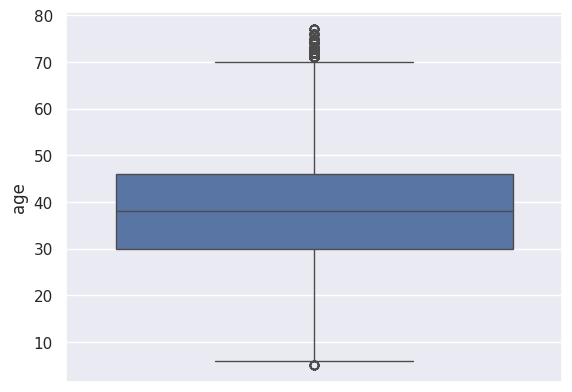

In [401]:
sns.boxplot(data=personal_data.age)

Замечено подозрительно большое количество вундеркиндов с высшим образованием в 14 лет или средним в 7, так что буду удалять аномалии

In [402]:
personal_data = personal_data[personal_data['age'] > 15]
personal_data = personal_data[~((personal_data['education'] == 'высшее') & (personal_data['age'] < 18))]
personal_data[personal_data['age'] < 19]['education'].value_counts()

,count
education,
высшее,1198
среднее,159


<Axes: ylabel='age'>

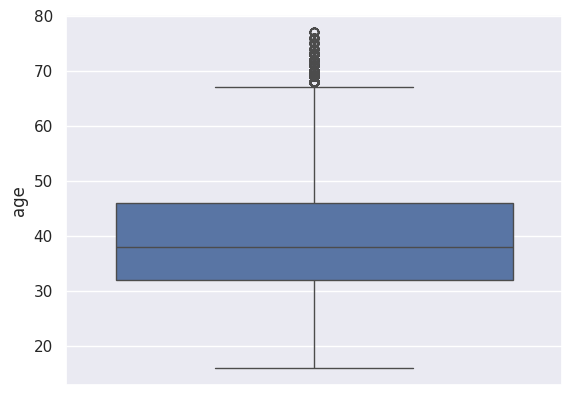

In [403]:
sns.boxplot(data=personal_data.age)

In [404]:
before = personal_data.shape[0]

<Axes: ylabel='age'>

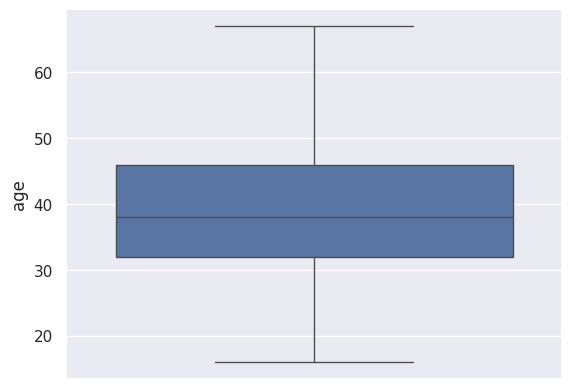

In [405]:
q25 = personal_data.age.quantile(0.25)
q75 = personal_data.age.quantile(0.75)
iqr = q75 - q25
low_bond = q25 - iqr*1.5
up_bond = q75 + iqr*1.5

personal_data = personal_data[(personal_data['age'] >= low_bond) & (personal_data['age'] <= up_bond)]
sns.boxplot(data=personal_data.age)

In [406]:
after = personal_data.shape[0]

In [407]:
print(f'before:{before}')
print(f'after:{after}')
print(f'разница: {before - after}')

before:99871
after:98775
разница: 1096


####Проверка на дубликаты

In [408]:
personal_data.duplicated().sum()

0

####Прочая работа

In [409]:
personal_data = personal_data[personal_data['country'] == 32]
personal_data.country.value_counts()

,count
country,
32,98251


## A/B тест

###Разделяю данные на тестовую и контрольные группы

Беру данные об айдишниках контрольной и тестовых групп, чищу их и помещаю в переменные

In [410]:
with open('/content/ids_first_company_positive.txt', 'r') as file:
    data = file.read()

data = data.replace('Ids of positive AB people ', '')
data = data.replace('ahashdgfjshjsd', ',')
data = data.replace(';', ',')
data = data.replace(' ', ',')
data = data.replace('\n', ',')
data = data.replace('dtj', ',')
data = data.replace('hfghfg', ',')
data = data.replace('yfsdftff', ',')
data = data.split(',')
fc_posotive = [int(i) for i in data if i != '']
positive = pd.Series(fc_posotive).drop_duplicates()
print(f'Количество дубликатов: {positive.duplicated().sum()}')
print(f'всего: {len(positive)}')

Количество дубликатов: 0
всего: 5020


In [411]:
with open('/content/ids_first_company_negative.txt', 'r') as file:
    data = file.read()

data = data.replace('Ids of negative AB people ', '')
data = data.replace('\n', '')

data = data.replace('hsdghdshgd', '')
data = data.replace('hdhdhdhd', '')
data = data.replace(',', ';')
data = data.replace(' ', ';')
data = data.replace('|||', ';')

data = data.replace('kdkdjff', ';')
data = data.replace('  ', ';')
data = data.split(';')
fc_negative = [int(i) for i in data if i != '']
negative = pd.Series(fc_negative)
print(f'Количество дубликатов: {negative.duplicated().sum()}')
print(f'всего: {len(negative)}')

Количество дубликатов: 0
всего: 5000


###Дизайн A/B теста

####Гипотеза

Н1: Предоставление скидки увеличивает количество заказов на пользователя

H0: Предоставление скидки не меняет количество заказов на пользователя

####Метрики

ключевой метрикой выберу:
1. количество заказов на пользователя


вспомогательные метрики:
1. средний чек на пользователя


####Значения уровня значимости и мощности

Возьму стандартные значения </br></br>
Уровень значимости 5% (0,05) </br>Мощность 80%

###Расчеты

####Предварительный анализ

In [412]:
purchases['ab_positive'] = purchases['id'].apply(lambda x: 1 if x in positive.values else 0)
purchases['ab_negative'] = purchases['id'].apply(lambda x: 1 if x in negative.values else 0)
purchases

,id,product,colour,cost,product_sex,base_sale,dt,ab_positive,ab_negative
0,0,"Велосипед горный женский Stern Mira 2.0 26""",мультицвет,13599,0.0,1,7,1,0
1,0,Стол Outventure,зеленый,1499,1.0,0,37,1,0
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,1.0,0,37,1,0
3,3,Бутсы мужские GSD Astro,белый,1599,2.0,0,13,0,0
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,1.0,0,27,0,0
...,...,...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,мультицвет,7999,2.0,0,12,0,0
786256,178004,Кроссовки мужские Nike Air Max 90,мультицвет,24299,2.0,0,13,0,0
786257,178004,Кроссовки мужские Nike Air Max 90,мультицвет,24299,2.0,0,20,0,0
786258,178004,Пакет,коричневый,12,1.0,0,20,0,0


In [413]:
purchases[(purchases['ab_positive'] == 1) & (purchases['ab_negative'] == 1)]

,id,product,colour,cost,product_sex,base_sale,dt,ab_positive,ab_negative
104,23,Шорты женские Demix,черный,1999,0.0,0,16,1,1
105,23,Лиф женский Joss,коралловый,649,0.0,1,16,1,1
106,23,Лиф женский Joss,синий,1399,0.0,1,58,1,1


In [414]:
if 23 in negative:
    print('23 есть в контрольной гр')

23 есть в контрольной гр


In [415]:
if 23 in positive:
    print('23 есть в тестовой гр')

23 есть в тестовой гр


In [416]:
pos_df = purchases[purchases['ab_positive'] == 1]
neg_df = purchases[purchases['ab_negative'] == 1]

In [417]:
pos_df = pos_df[pos_df['id'] != 23]
neg_df = neg_df[neg_df['id'] != 23]

In [418]:
pos_df.head()

,id,product,colour,cost,product_sex,base_sale,dt,ab_positive,ab_negative
0,0,"Велосипед горный женский Stern Mira 2.0 26""",мультицвет,13599,0.0,1,7,1,0
1,0,Стол Outventure,зеленый,1499,1.0,0,37,1,0
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,1.0,0,37,1,0
7,4,Роликовые коньки детские Roces Orlando III,мультицвет,9199,1.0,0,0,1,0
8,4,Шлем FILA NRK FUN,белый,4999,1.0,0,0,1,0


In [419]:
neg_df.head()

,id,product,colour,cost,product_sex,base_sale,dt,ab_positive,ab_negative
297,70,Кроссовки мужские Reebok Lite Plus 3,мультицвет,7399,2.0,0,4,0,1
298,70,Сандалии женские Outventure Athens W,графитовый,3999,0.0,0,5,0,1
299,70,Кроссовки мужские FILA Chain Smr,хаки,5999,2.0,0,16,0,1
300,70,Майка женская Demix,мультицвет,799,0.0,1,38,0,1
306,75,Джемпер флисовый женский Outventure,неизвестно,4499,0.0,0,15,0,1


In [420]:
pos_df.groupby('id')['dt'].min().value_counts()

,count
dt,
0,1000
1,716
5,709
2,590
4,570
3,560
7,144
6,110
8,93


In [421]:
neg_df.groupby('id')['dt'].min().value_counts()

,count
dt,
16,1497
0,513
1,318
15,268
14,252
2,250
7,237
3,227
10,214


Сначала не понял почему среди тестовой группы есть заказы с датой заказа позднее 16 дня (марк. компания проводилась с 5 по 16). Но потом догадался, что клиенты могли первый заказ сделать по скидке, но потом, через несколько дней или недель вернуться и снова купить товары, только уже не по скидке. Ну или же те, у кого первый заказ был позднее 16 дня, просто не воспользовались скидкой во время акции (хотя были включены в тестовую группу), но приобрели что то позже

In [422]:
pos_df.groupby('id').count().reset_index()['id']

,id
0,0
1,4
2,6
3,9
4,13
...,...
5001,177918
5002,177924
5003,177946
5004,177965


In [423]:
neg_df.groupby('id').count().reset_index()['id']

,id
0,70
1,75
2,110
3,168
4,205
...,...
4994,177764
4995,177839
4996,177899
4997,177963


####Расчет и анализ метрик

#####Количество заказов на пользователя

Н1: Предоставление скидки увеличивает количество заказов на пользователя

H0: Предоставление скидки не меняет количество заказов на пользователя

In [424]:
count_df_control = neg_df.groupby('id')['ab_positive'].count()
count_df_control = count_df_control.reset_index()
count_df_test = pos_df.groupby('id')['ab_positive'].count()
count_df_test = count_df_test.reset_index()

In [425]:
count_df_control['ab_positive'].mean()

11.169633926785357

In [426]:
count_df_test['ab_positive'].mean()

12.86596084698362

В тестовых данных среднее больше, проверим разницу на стат. значимость

In [427]:
shapiro(count_df_control)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9998.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=0.7658444480036898, pvalue=5.408795255912842e-80)

In [428]:
shapiro(count_df_test)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10012.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=0.7630110860647777, pvalue=2.7244073359903974e-80)

Воспользуюсь T-тестом Стьюдента

In [429]:
stat, p_value = ttest_ind(count_df_control['ab_positive'], count_df_test['ab_positive'])

print(f"U-статистика: {stat}")
print(f"p-value: {p_value}")

if p_value>0.05:
    print('Оставляем нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

U-статистика: -5.027357221207257
p-value: 5.059031575212732e-07
Отвергаем нулевую гипотезу


Мы отвергли нулеувю гипотезу, следовательно мы делаем вывод, что разница статистически значима и предоставление скидки увеличивает количество заказов на пользователя

#####Средний чек на пользователя

In [430]:
cost_df_control = neg_df.groupby('id')['cost'].mean()
cost_df_test = pos_df.groupby('id')['cost'].mean()

In [431]:
cost_df_control.mean()

5831.249536393863

In [432]:
cost_df_test.mean()

5596.397526377105

Средний чек на пользователя в тестовой группе оказался ниже. Проверим на стат. значимость

In [433]:
shapiro(cost_df_control)

ShapiroResult(statistic=0.5849252071924085, pvalue=3.591188865148173e-76)

In [434]:
shapiro(cost_df_test)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5006.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=0.6063242517612981, pvalue=4.3024119127203903e-75)

Воспользуюсь Т тестом Стьюдента

In [435]:
stat, p_value = ttest_ind(cost_df_control, cost_df_test, alternative='two-sided')

print(f"U-статистика: {stat}")
print(f"p-value: {p_value}")

if p_value>0.05:
    print('Оставляем нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

U-статистика: 1.9979353469009062
p-value: 0.04575069751167191
Отвергаем нулевую гипотезу


мы отвергли нулевую гипотезу, следовательно в тестовой группе статистически ниже средний чек.

###Бизнес рекомендация

Продолжить проводить маркетинговые компании со скидками, однако пересмотреть формат скидок (процентные скидки, минимальная сумма для скидки, скидки на высокомаржинальные продукты) или стимулировать увеличение среднего чека через кросс-продажи и upselling.

Пояснение:</br>
Основная цель маркетинговой компании достигнута, люди стали покупать больше товаров, однако упал средний чек на пользователя, из чего следует, что люди пусть и стали покупать больше товаров, но они концентрировались на более дешевых товарах. С этим очень хорошо помогла бы процентная скидка: чем дороже товар - тем выгоднее клиенту покупать его. Так же можно повысить средний чек через cross selling и upselling, когда клиентам, при покупке товара, предлагается такой же товар, но качеством лучше, либо мелкие товары, дополняющие основной товар.

##Кластерный анализ

###Выявление кластеров

In [436]:
purchases

,id,product,colour,cost,product_sex,base_sale,dt,ab_positive,ab_negative
0,0,"Велосипед горный женский Stern Mira 2.0 26""",мультицвет,13599,0.0,1,7,1,0
1,0,Стол Outventure,зеленый,1499,1.0,0,37,1,0
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,1.0,0,37,1,0
3,3,Бутсы мужские GSD Astro,белый,1599,2.0,0,13,0,0
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,1.0,0,27,0,0
...,...,...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,мультицвет,7999,2.0,0,12,0,0
786256,178004,Кроссовки мужские Nike Air Max 90,мультицвет,24299,2.0,0,13,0,0
786257,178004,Кроссовки мужские Nike Air Max 90,мультицвет,24299,2.0,0,20,0,0
786258,178004,Пакет,коричневый,12,1.0,0,20,0,0


In [437]:
personal_data

,id,gender,age,education,city,country
0,0,0.0,36,среднее,1201,32
1,4,0.0,35,среднее,1134,32
2,6,1.0,52,среднее,1188,32
3,7,0.0,37,среднее,1198,32
4,9,0.0,48,среднее,1134,32
...,...,...,...,...,...,...
15742,103811,1.0,50,среднее,1157,32
15743,135183,1.0,44,среднее,1134,32
15744,125993,1.0,46,среднее,1134,32
15746,116355,1.0,32,среднее,1188,32


In [438]:
df = personal_data.copy()
df = df.merge(personal_data_coeffs[['id', 'personal_coef']], how='left', on='id')
df = df.merge(purchases.groupby('id').count().reset_index()[['id', 'product']], on='id', how='left')
df.rename(columns={'product' : 'count_purchs'}, inplace=True)
df = df.merge(purchases.groupby('id')['cost'].mean().reset_index()[['id','cost']], how='left', on='id').rename(columns={'cost':'mean_cost'})

In [439]:
df

,id,gender,age,education,city,country,personal_coef,count_purchs,mean_cost
0,0,0.0,36,среднее,1201,32,0.5072,3,6632.333333
1,4,0.0,35,среднее,1134,32,0.5072,7,4441.857143
2,6,1.0,52,среднее,1188,32,0.4304,15,5605.666667
3,7,0.0,37,среднее,1198,32,0.5072,13,4525.153846
4,9,0.0,48,среднее,1134,32,0.5072,10,6329.000000
...,...,...,...,...,...,...,...,...,...
98246,103811,1.0,50,среднее,1157,32,0.4304,2,1084.000000
98247,135183,1.0,44,среднее,1134,32,0.4304,6,8714.000000
98248,125993,1.0,46,среднее,1134,32,0.4304,6,3545.666667
98249,116355,1.0,32,среднее,1188,32,0.4304,5,23699.000000


In [440]:
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df.drop(columns=['country', 'city'], inplace=True)
df

,id,gender,age,education,personal_coef,count_purchs,mean_cost
0,0,0.0,36,1,0.5072,3,6632.333333
1,4,0.0,35,1,0.5072,7,4441.857143
2,6,1.0,52,1,0.4304,15,5605.666667
3,7,0.0,37,1,0.5072,13,4525.153846
4,9,0.0,48,1,0.5072,10,6329.000000
...,...,...,...,...,...,...,...
98246,103811,1.0,50,1,0.4304,2,1084.000000
98247,135183,1.0,44,1,0.4304,6,8714.000000
98248,125993,1.0,46,1,0.4304,6,3545.666667
98249,116355,1.0,32,1,0.4304,5,23699.000000


In [441]:
sampled_df = df.sample(n=10000, random_state=42)
sampled_df_with_id = sampled_df.copy()
sampled_df.drop('id', axis=1, inplace=True)
sampled_df

,gender,age,education,personal_coef,count_purchs,mean_cost
25396,1.0,29,1,0.4304,4,2469.000000
64395,1.0,43,1,0.4304,6,2944.000000
16131,1.0,41,1,0.4304,12,8732.333333
3030,1.0,61,1,0.4304,8,3229.000000
40781,0.0,34,1,0.5072,4,4406.500000
...,...,...,...,...,...,...
20596,0.0,51,1,0.5072,9,3052.333333
66978,0.0,51,1,0.5072,6,5265.666667
96005,1.0,50,1,0.4304,1,5499.000000
69099,1.0,36,1,0.4304,4,9130.250000


In [442]:
ss = StandardScaler()
scaled_data = ss.fit_transform(sampled_df)

In [443]:
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(scaled_data)

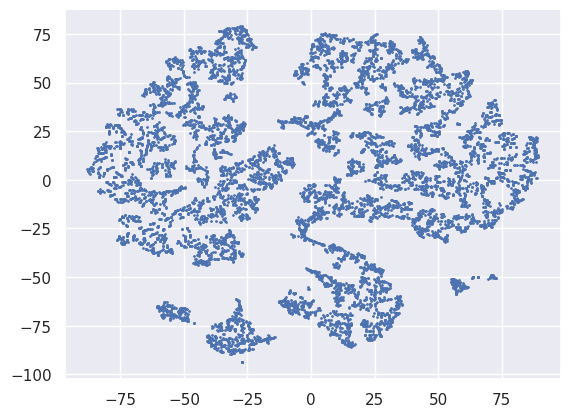

In [444]:
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=1)

In [445]:
agg_clustering = AgglomerativeClustering(n_clusters=3).fit(scaled_data)
np.unique(agg_clustering.labels_)

array([0, 1, 2])

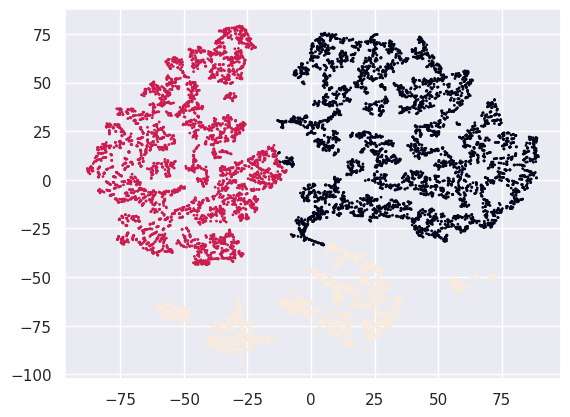

In [446]:
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=1, c = agg_clustering.labels_)

In [447]:
N=15
inertia=[]
silh=[]
for i in range(2, N):
    km = KMeans(n_clusters=i, random_state=1).fit(scaled_data)
    inertia.append(km.inertia_)
    preds = km.predict(scaled_data)
    silh.append(silhouette_score(scaled_data, preds))

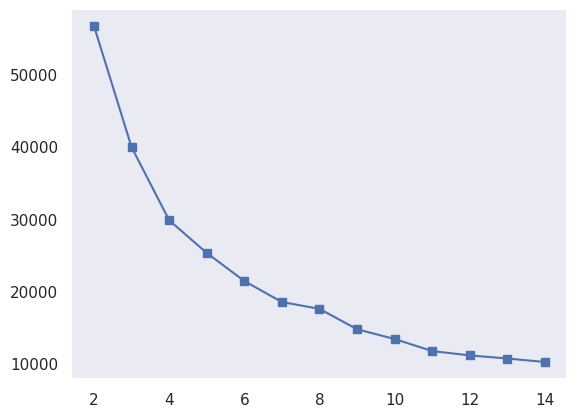

In [448]:
plt.plot(np.arange(2, N), inertia, marker='s')
plt.grid()
plt.show()

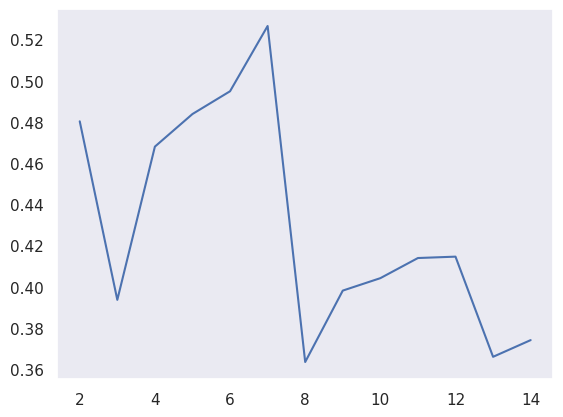

In [449]:
plt.plot(np.arange(2, N), silh)
plt.grid()
plt.show()

Выберу 4 кластера для KMeans

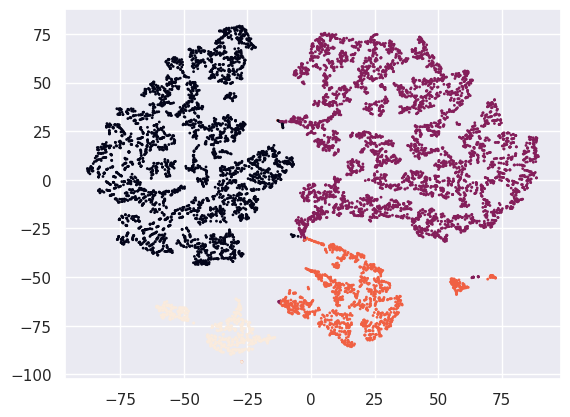

In [450]:
kmeans = KMeans(n_clusters=4, random_state=2).fit(scaled_data)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=1, c = kmeans.labels_)

###Визуализации

<ipython-input-451-20c1176496be>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(kind='box', data=sampled_df, x=kmeans.labels_, y='age', palette='colorblind')


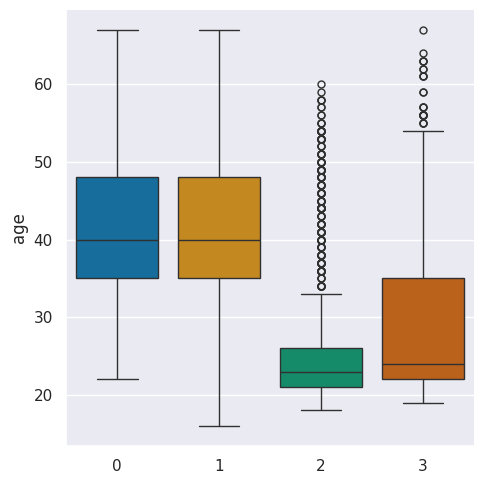

In [451]:
sns.catplot(kind='box', data=sampled_df, x=kmeans.labels_, y='age', palette='colorblind')
plt.tight_layout()
plt.show()

<ipython-input-452-8f5c9d3d253d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(kind='box', data=sampled_df, x=kmeans.labels_, y='gender', palette='colorblind')


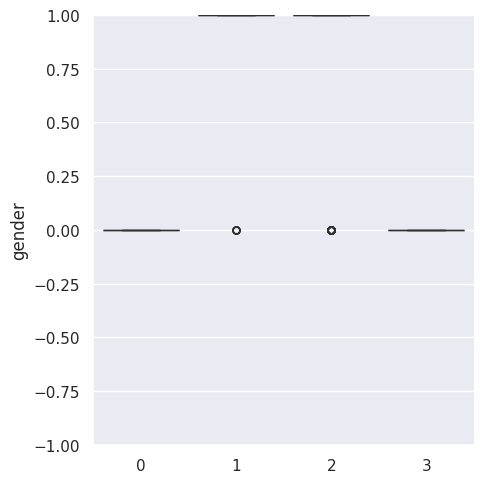

In [452]:
sns.catplot(kind='box', data=sampled_df, x=kmeans.labels_, y='gender', palette='colorblind')
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()

<ipython-input-453-57ca5905183e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(kind='box', data=sampled_df, x=kmeans.labels_, y='mean_cost', palette='colorblind')


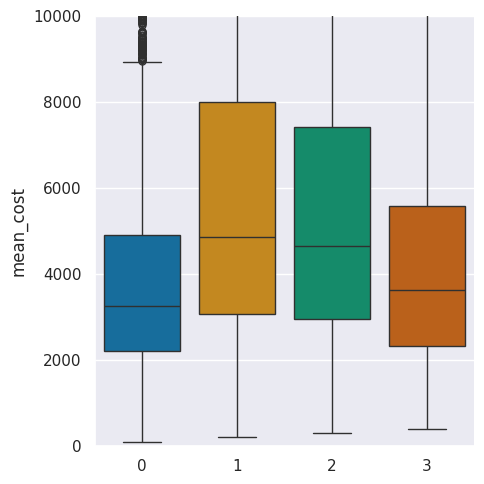

In [453]:
sns.catplot(kind='box', data=sampled_df, x=kmeans.labels_, y='mean_cost', palette='colorblind')
plt.ylim(0, 10000)
plt.tight_layout()
plt.show()

In [454]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3], dtype=int32)

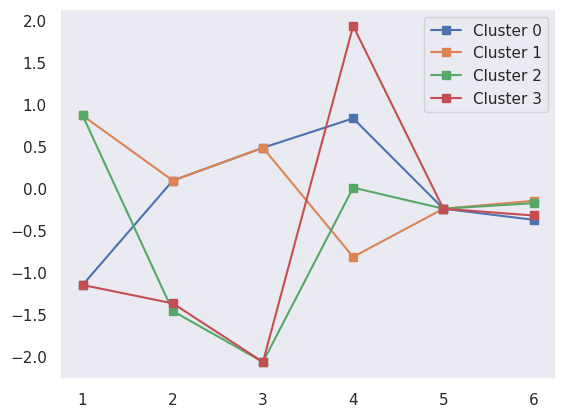

In [455]:
for i in range(4):
    plt.plot(range(1, scaled_data.shape[1]+1), np.median(scaled_data[kmeans.labels_ == i, :], axis=0), marker='s', label=f'Cluster {i}')

plt.grid()
plt.legend()
plt.show()

###Анализ кластеров

In [456]:
clusters = kmeans.fit_predict(scaled_data)
sampled_df_with_id['cluster'] = clusters
cl0_data = sampled_df_with_id[sampled_df_with_id['cluster'] == 0]
cl1_data = sampled_df_with_id[sampled_df_with_id['cluster'] == 1]
cl2_data = sampled_df_with_id[sampled_df_with_id['cluster'] == 2]
cl3_data = sampled_df_with_id[sampled_df_with_id['cluster'] == 3]
print(f'Статистика кластера 0:\n\n {cl0_data.describe()}\n\n\n\n')
print(f'Статистика кластера 1:\n\n {cl1_data.describe()}\n\n\n\n')
print(f'Статистика кластера 2:\n\n {cl2_data.describe()}\n\n\n\n')
print(f'Статистика кластера 3:\n\n {cl3_data.describe()}\n\n\n\n')

Статистика кластера 0:

                   id  gender          age  education  personal_coef  \
count    3681.000000  3681.0  3681.000000     3681.0    3681.000000   
mean    88263.961424     0.0    42.101874        1.0       0.507075   
std     51946.008637     0.0     8.917356        0.0       0.003099   
min       214.000000     0.0    22.000000        1.0       0.430400   
25%     42973.000000     0.0    35.000000        1.0       0.507200   
50%     86648.000000     0.0    40.000000        1.0       0.507200   
75%    133669.000000     0.0    48.000000        1.0       0.507200   
max    177983.000000     0.0    67.000000        1.0       0.507200   

       count_purchs     mean_cost  cluster  
count   3681.000000   3681.000000   3681.0  
mean       7.704156   4285.365565      0.0  
std        9.915085   4027.118030      0.0  
min        1.000000     99.000000      0.0  
25%        3.000000   2199.000000      0.0  
50%        5.000000   3260.666667      0.0  
75%        9.000000 

In [457]:
cl0_ids = np.unique(cl0_data.id)
cl1_ids = np.unique(cl1_data.id)
cl2_ids = np.unique(cl2_data.id)
cl3_ids = np.unique(cl3_data.id)

cl0_purchs = purchases[purchases['id'].isin(cl0_ids)]
cl1_purchs = purchases[purchases['id'].isin(cl1_ids)]
cl2_purchs = purchases[purchases['id'].isin(cl2_ids)]
cl3_purchs = purchases[purchases['id'].isin(cl3_ids)]

####Кластер 1

In [458]:
sale_percent0 = cl0_purchs[cl0_purchs['base_sale'] == 1].shape[0]/cl0_purchs.shape[0] * 100

In [459]:
print(f'КЛАСТЕР 1\nЛюдей: {cl0_data.shape[0]}\nПокупок: {cl0_purchs.shape[0]}\nПроцент покупок по скидке: {round(sale_percent0, 1)}% \
\nОсновной пол: женский \nСредний возраст: {round(cl0_data.age.mean(), 2)}\nЛюбимые продукты:')
cl0_purchs['product'].value_counts().head(15)

КЛАСТЕР 1
Людей: 3681
Покупок: 28359
Процент покупок по скидке: 40.3% 
Основной пол: женский 
Средний возраст: 42.1
Любимые продукты:


,count
product,
Футболка женская Demix,233
Лиф женский Joss,199
Купальник женский Joss,185
Плавки женские Joss,161
Легинсы женские Demix,158
Брюки женские FILA,143
Купальник женский FILA,138
Брюки женские Outventure,137
Балетки женские Demix Ballerina 2,128


####Кластер 2

In [460]:
sale_percent1 = cl1_purchs[cl1_purchs['base_sale'] == 1].shape[0]/cl1_purchs.shape[0] * 100

In [461]:
print(f'КЛАСТЕР 2\nЛюдей: {cl1_data.shape[0]}\nПокупок: {cl1_purchs.shape[0]}\nПроцент покупок по скидке: {round(sale_percent1, 1)}% \
\nОсновной пол: мужской \nСредний возраст: {round(cl1_data.age.mean(), 2)}\nЛюбимые продукты:')
cl1_purchs['product'].value_counts().head(15)

КЛАСТЕР 2
Людей: 4434
Покупок: 33199
Процент покупок по скидке: 31.5% 
Основной пол: мужской 
Средний возраст: 41.63
Любимые продукты:


,count
product,
Брюки мужские Demix,336
Шорты мужские Demix,258
Футболка мужская Demix,221
Брюки мужские Outventure,205
Брюки мужские FILA,137
Толстовка мужская Demix,133
Сабо Crocs Crocband,107
Солнцезащитные очки Kappa,98
Брюки мужские Northland,89


####Кластер 3

In [462]:
sale_percent2 = cl2_purchs[cl2_purchs['base_sale'] == 1].shape[0]/cl2_purchs.shape[0] * 100

In [463]:
print(f'КЛАСТЕР 3\nЛюдей: {cl2_data.shape[0]}\nПокупок: {cl2_purchs.shape[0]}\nПроцент покупок по скидке: {round(sale_percent2, 1)}% \
\nОсновной пол: мужской \nСредний возраст: {round(cl2_data.age.mean(), 2)}\nЛюбимые продукты:')
cl2_purchs['product'].value_counts().head(15)

КЛАСТЕР 3
Людей: 1311
Покупок: 9243
Процент покупок по скидке: 31.1% 
Основной пол: мужской 
Средний возраст: 25.72
Любимые продукты:


,count
product,
Шорты мужские Demix,89
Футболка мужская Demix,71
Брюки мужские FILA,69
Брюки мужские Demix,69
Шорты мужские Nike,44
Сабо Crocs Crocband,33
Футболка мужская Termit,33
Брюки мужские Outventure,27
Футболка мужская FILA,27


####Кластер 4

In [464]:
sale_percent3 = cl3_purchs[cl3_purchs['base_sale'] == 1].shape[0]/cl3_purchs.shape[0] * 100

In [465]:
print(f'КЛАСТЕР 4\nЛюдей: {cl3_data.shape[0]}\nПокупок: {cl3_purchs.shape[0]}\nПроцент покупок по скидке: {round(sale_percent3, 1)}% \
\nОсновной пол: женский \nСредний возраст: {round(cl3_data.age.mean(), 2)}\nЛюбимые продукты:')
cl3_purchs['product'].value_counts().head(15)

КЛАСТЕР 4
Людей: 574
Покупок: 4092
Процент покупок по скидке: 39.6% 
Основной пол: женский 
Средний возраст: 29.24
Любимые продукты:


,count
product,
Плавки женские Joss,37
Футболка женская Demix,37
Лиф женский Joss,35
Купальник женский Joss,27
Легинсы женские Demix,26
Шорты женские Demix,23
Брюки женские Demix,23
Брюки женские Outventure,23
Сандалии женские Skechers Arch Fit,22


###Визуализация

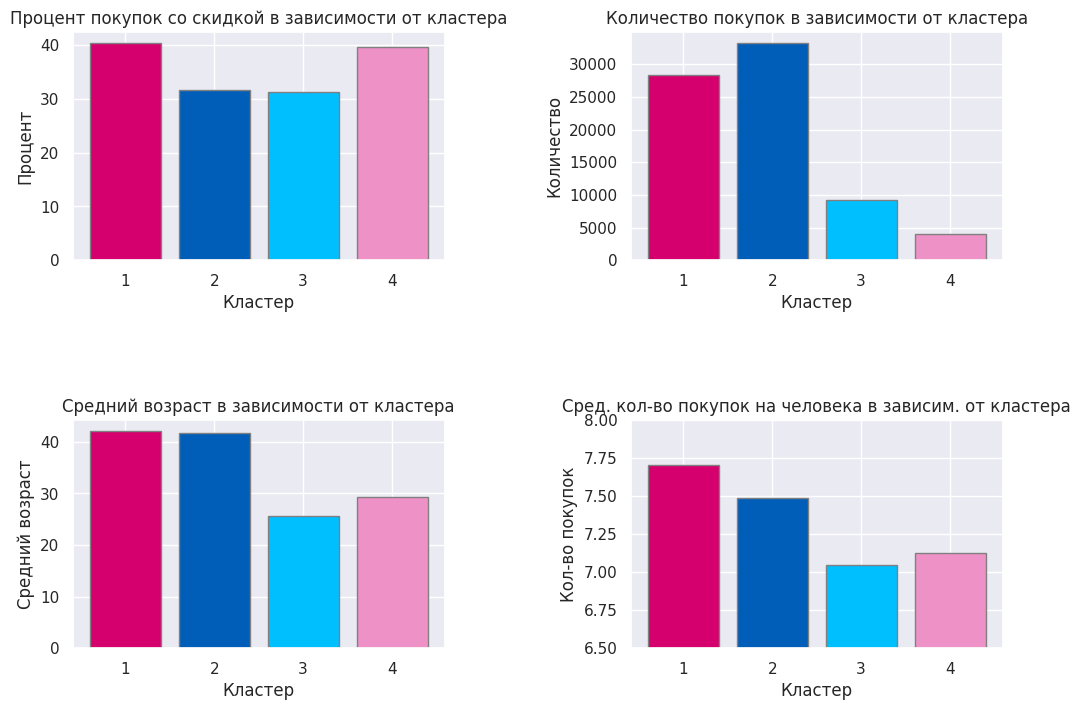

In [466]:
sns.set()

fig, axs = plt.subplots(2, 2, figsize=(12,8))
pastel_colors = ['#D5006D', '#005EB8', '#00BFFF', '#ed91c7']

axs[0, 0].bar(['1', '2', '3', '4'], [sale_percent0, sale_percent1, sale_percent2, sale_percent3], color = pastel_colors, edgecolor='gray')
axs[0, 0].set_title('Процент покупок со скидкой в зависимости от кластера')
axs[0, 0].set_ylabel('Процент')
axs[0, 0].set_xlabel('Кластер')

axs[0, 1].bar(['1', '2', '3', '4'], \
[cl0_purchs.shape[0], cl1_purchs.shape[0], cl2_purchs.shape[0], cl3_purchs.shape[0]], color = pastel_colors, edgecolor='gray')
axs[0, 1].set_title('Количество покупок в зависимости от кластера')
axs[0, 1].set_ylabel('Количество')
axs[0, 1].set_xlabel('Кластер')

axs[1, 0].bar(['1', '2', '3', '4'], \
[cl0_data.age.mean(), cl1_data.age.mean() , cl2_data.age.mean(), cl3_data.age.mean()], color = pastel_colors, edgecolor='gray')
axs[1, 0].set_title('Средний возраст в зависимости от кластера')
axs[1, 0].set_ylabel('Средний возраст')
axs[1, 0].set_xlabel('Кластер')

axs[1, 1].bar(['1', '2', '3', '4'], \
[cl0_purchs.shape[0]/cl0_data.shape[0], cl1_purchs.shape[0]/cl1_data.shape[0], cl2_purchs.shape[0]/cl2_data.shape[0], cl3_purchs.shape[0]/cl3_data.shape[0]], \
color = pastel_colors, edgecolor='gray')
axs[1, 1].set_title('Сред. кол-во покупок на человека в зависим. от кластера')
axs[1, 1].set_ylabel('Кол-во покупок')
axs[1, 1].set_xlabel('Кластер')
axs[1, 1].set_ylim(6.5,8)

plt.subplots_adjust(wspace=0.5, hspace=0.7)
plt.show()

###Результаты анализа

В итоге мы имеем 4 кластера, которые по большей части делят людей по их полу и возрасту.</br></br>
1 и 4 кластеры - это зрелые и более молодые женщины соответсвенно</br>
2 и 3 кластеры - это зрелые и более молодые мужчины соответсвенно

В результате анализа, я выяснил следующее:</br></br></br>

1. Женщины обоих возрастных категорий чаще покупают товары по скидке, чем мужчины.

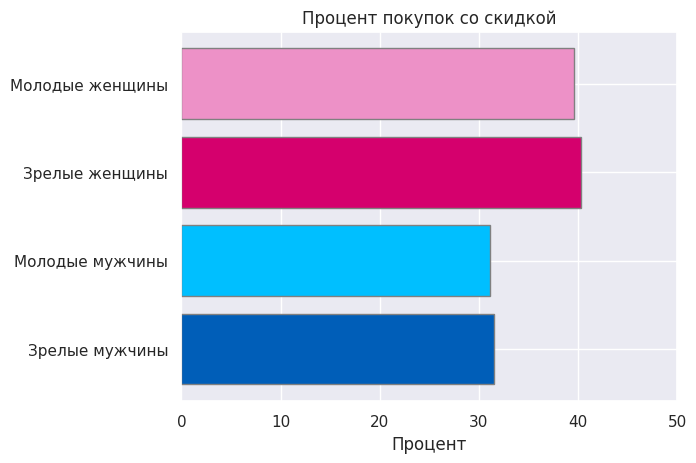

In [467]:
pastel_colors = ['#005EB8', '#00BFFF', '#D5006D', '#ed91c7']
plt.barh(['Зрелые мужчины', 'Молодые мужчины', 'Зрелые женщины', 'Молодые женщины'], \
[sale_percent1, sale_percent2, sale_percent0, sale_percent3], color = pastel_colors, edgecolor='gray')
plt.title('Процент покупок со скидкой')
plt.xlabel('Процент')
plt.xlim(0, 50)
plt.show()

</br></br></br></br>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

</br></br></br></br>2. Более зрелые люди делают больше покупок чем молодые

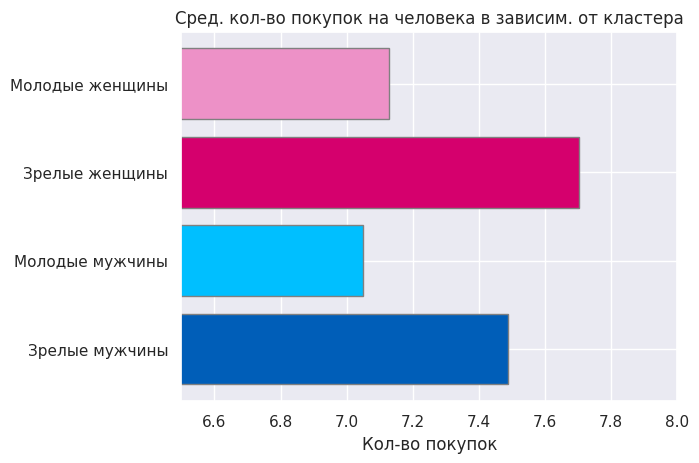

In [468]:
pastel_colors = ['#005EB8', '#00BFFF', '#D5006D', '#ed91c7']
plt.barh(['Зрелые мужчины', 'Молодые мужчины', 'Зрелые женщины', 'Молодые женщины'], \
[cl1_purchs.shape[0]/cl1_data.shape[0], cl2_purchs.shape[0]/cl2_data.shape[0], cl0_purchs.shape[0]/cl0_data.shape[0], cl3_purchs.shape[0]/cl3_data.shape[0]], \
color = pastel_colors, edgecolor='gray')
plt.title('Сред. кол-во покупок на человека в зависим. от кластера')
plt.xlabel('Кол-во покупок')
plt.xlim(6.5,8)
plt.show()

</br></br></br></br>--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

</br></br></br></br>3. Агрегируя по возрастным категориям, женщины делают больше покупок нежели мужчины

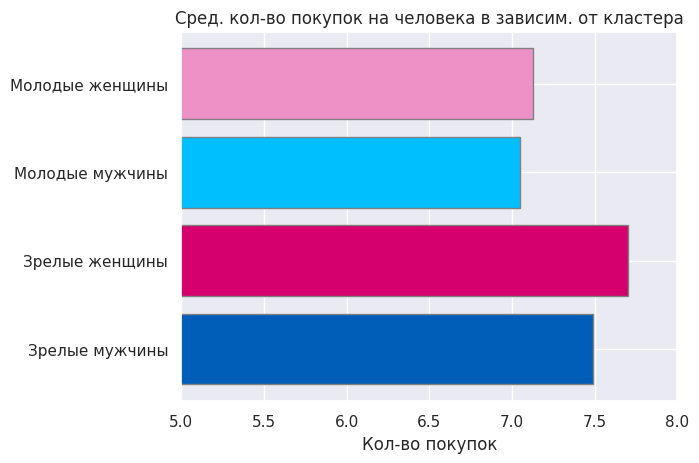

In [469]:
pastel_colors = ['#005EB8', '#D5006D',  '#00BFFF', '#ed91c7']
plt.barh(['Зрелые мужчины','Зрелые женщины', 'Молодые мужчины',  'Молодые женщины'], \
[cl1_purchs.shape[0]/cl1_data.shape[0], cl0_purchs.shape[0]/cl0_data.shape[0], cl2_purchs.shape[0]/cl2_data.shape[0], cl3_purchs.shape[0]/cl3_data.shape[0]], \
color = pastel_colors, edgecolor='gray')
plt.title('Сред. кол-во покупок на человека в зависим. от кластера')
plt.xlabel('Кол-во покупок')
plt.xlim(5,8)
plt.show()

</br></br></br></br>

Какие товары предпочитают разные кластеры?

In [470]:
print(f'Молодые женщины предпочитают:')
cl3_purchs['product'].value_counts().reset_index().head(10)['product']

Молодые женщины предпочитают:


,product
0,Плавки женские Joss
1,Футболка женская Demix
2,Лиф женский Joss
3,Купальник женский Joss
4,Легинсы женские Demix
5,Шорты женские Demix
6,Брюки женские Demix
7,Брюки женские Outventure
8,Сандалии женские Skechers Arch Fit
9,Брюки женские FILA


In [471]:
print(f'Зрелые женщины предпочитают:')
cl0_purchs['product'].value_counts().reset_index().head(10)['product']

Зрелые женщины предпочитают:


,product
0,Футболка женская Demix
1,Лиф женский Joss
2,Купальник женский Joss
3,Плавки женские Joss
4,Легинсы женские Demix
5,Брюки женские FILA
6,Купальник женский FILA
7,Брюки женские Outventure
8,Балетки женские Demix Ballerina 2
9,Брюки женские Demix


In [472]:
print(f'Молодые мужчины предпочитают:')
cl2_purchs['product'].value_counts().reset_index().head(10)['product']

Молодые мужчины предпочитают:


,product
0,Шорты мужские Demix
1,Футболка мужская Demix
2,Брюки мужские FILA
3,Брюки мужские Demix
4,Шорты мужские Nike
5,Сабо Crocs Crocband
6,Футболка мужская Termit
7,Брюки мужские Outventure
8,Футболка мужская FILA
9,Шорты плавательные мужские Joss


In [473]:
print(f'Зрелые мужчины предпочитают:')
cl1_purchs['product'].value_counts().reset_index().head(10)['product']

Зрелые мужчины предпочитают:


,product
0,Брюки мужские Demix
1,Шорты мужские Demix
2,Футболка мужская Demix
3,Брюки мужские Outventure
4,Брюки мужские FILA
5,Толстовка мужская Demix
6,Сабо Crocs Crocband
7,Солнцезащитные очки Kappa
8,Брюки мужские Northland
9,Футболка мужская Termit


##Информация о жителях страны 32 города 1 188

In [474]:
main_df = personal_data.merge(personal_data_coeffs[['id', 'personal_coef']], how='left', on='id')
main_df['first_company'] = main_df['id'].apply(lambda x: 1 if x in positive.values else 0)

In [475]:
ids_1134city = main_df[main_df['city'] == 1134].id.unique()
ids_1134city

array([     4,      9,     12, ...,  53816, 135183, 125993])

In [476]:
purchases.drop('ab_negative', axis=1, inplace=True)

In [477]:
purchases.rename({'ab_positive' : 'first_company'}, axis=1, inplace=True)
purchases['second_company'] = purchases.apply(lambda x: 1 if ((x['id'] in ids_1134city) and ((x['dt'] == 15) or (x['dt'] == 45))) else 0, axis=1)

In [478]:
main_df = main_df.merge(purchases.groupby('id')['second_company'].sum().reset_index(), how='left', on='id')

In [479]:
s1 = purchases.groupby('id')['product'].count().reset_index()
main_df = main_df.merge(s1, how='left', on='id')

In [480]:
main_df = main_df.rename({'product' : 'purch_count'}, axis=1)

In [481]:
main_df = main_df.merge(purchases.groupby('id')['cost'].mean().reset_index(), on='id', how='left')
main_df.rename({'cost': 'mean_cost'}, axis=1, inplace=True)

In [482]:
mean_purch_count = main_df.purch_count.mean()
main_df['target'] = main_df['purch_count'].apply(lambda x: 1 if x > mean_purch_count else 0 )
main_df

,id,gender,age,education,city,country,personal_coef,first_company,second_company,purch_count,mean_cost,target
0,0,0.0,36,среднее,1201,32,0.5072,1,0,3,6632.333333,0
1,4,0.0,35,среднее,1134,32,0.5072,1,0,7,4441.857143,0
2,6,1.0,52,среднее,1188,32,0.4304,1,0,15,5605.666667,1
3,7,0.0,37,среднее,1198,32,0.5072,0,0,13,4525.153846,1
4,9,0.0,48,среднее,1134,32,0.5072,1,0,10,6329.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
98246,103811,1.0,50,среднее,1157,32,0.4304,0,0,2,1084.000000,0
98247,135183,1.0,44,среднее,1134,32,0.4304,0,2,6,8714.000000,0
98248,125993,1.0,46,среднее,1134,32,0.4304,0,0,6,3545.666667,0
98249,116355,1.0,32,среднее,1188,32,0.4304,0,0,5,23699.000000,0


In [483]:
prev_data = main_df.drop(['country', 'id'], axis=1)

In [484]:
le = LabelEncoder()
prev_data['education'] = le.fit_transform(prev_data['education'])
prev_data

,gender,age,education,city,personal_coef,first_company,second_company,purch_count,mean_cost,target
0,0.0,36,1,1201,0.5072,1,0,3,6632.333333,0
1,0.0,35,1,1134,0.5072,1,0,7,4441.857143,0
2,1.0,52,1,1188,0.4304,1,0,15,5605.666667,1
3,0.0,37,1,1198,0.5072,0,0,13,4525.153846,1
4,0.0,48,1,1134,0.5072,1,0,10,6329.000000,1
...,...,...,...,...,...,...,...,...,...,...
98246,1.0,50,1,1157,0.4304,0,0,2,1084.000000,0
98247,1.0,44,1,1134,0.4304,0,2,6,8714.000000,0
98248,1.0,46,1,1134,0.4304,0,0,6,3545.666667,0
98249,1.0,32,1,1188,0.4304,0,0,5,23699.000000,0


In [485]:
prev_data.columns

Index(['gender', 'age', 'education', 'city', 'personal_coef', 'first_company',
       'second_company', 'purch_count', 'mean_cost', 'target'],
      dtype='object')

In [486]:
train = prev_data[prev_data['city'] != 1188]
test = prev_data[prev_data['city'] == 1188]

In [487]:
sc = StandardScaler()

train[['gender', 'age', 'education', 'city', 'personal_coef', 'first_company',
       'second_company', 'purch_count', 'mean_cost']] = sc.fit_transform(train[['gender', 'age', 'education', 'city', 'personal_coef', 'first_company',
       'second_company', 'purch_count', 'mean_cost']])

test[['gender', 'age', 'education', 'city', 'personal_coef', 'first_company',
       'second_company', 'purch_count', 'mean_cost']] = sc.fit_transform(test[['gender', 'age', 'education', 'city', 'personal_coef', 'first_company',
       'second_company', 'purch_count', 'mean_cost']])

<ipython-input-487-f4153064885f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['gender', 'age', 'education', 'city', 'personal_coef', 'first_company',
<ipython-input-487-f4153064885f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['gender', 'age', 'education', 'city', 'personal_coef', 'first_company',


In [488]:
train.drop(['city', 'purch_count'], axis=1, inplace=True)
test.drop(['city', 'purch_count'], axis=1, inplace=True)

<ipython-input-488-7e7dc59f32b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['city', 'purch_count'], axis=1, inplace=True)
<ipython-input-488-7e7dc59f32b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['city', 'purch_count'], axis=1, inplace=True)


In [489]:
X_train = train.drop('target', axis=1)
X_test = test.drop('target', axis=1)
y_train = train['target']
y_test = test['target']

In [490]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

cross_val = cross_val_score(lr, X_train, y_train, cv=10, scoring='accuracy')

In [491]:
print(f'точность по кросс валидации: {cross_val.round(3)}')
print(f'средняя точность по кросс валидации: {cross_val.mean().round(3)}')

точность по кросс валидации: [0.709 0.71  0.708 0.707 0.706 0.707 0.708 0.705 0.708 0.701]
средняя точность по кросс валидации: 0.707


In [492]:
y_pred = lr.predict(X_test)
pd.Series(y_pred).value_counts()

,count
0,11294
1,490
